<h1>Q3.1 Excat Inference</h1>

In [76]:
from itertools import product
from math import exp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


class MessagePassing:
    def __init__(self, beta : float):
        self.beta = beta
        self.all_column_configs = [''.join(bits) for bits in product('01', repeat=10)]

    def get_within_column_potential(self, config):
        pi = 1
        for i in range(len(config) - 1):
            if config[i] == config[i+1]:
                pi *= exp(self.beta)
        return pi

    def row_neighbor_phi(self, c_i, c_j):
        pi = 1
        for k in range(len(c_i)):
            if c_i[k] == c_j[k]:
                pi *= exp(self.beta)
        return pi

    def get_factor_matrix(self):
        within_column_potentials = [self.get_within_column_potential(c) for c in self.all_column_configs]
        
        between_column_potentials = np.zeros((len(self.all_column_configs), len(self.all_column_configs)))
        for i in range(len(self.all_column_configs)):
            c_i = self.all_column_configs[i]
            for j in range(i, len(self.all_column_configs)):
                c_j = self.all_column_configs[j]
                between_column_potentials[i][j] = self.row_neighbor_phi(c_i, c_j)
                between_column_potentials[j][i] = between_column_potentials[i][j]

        factor = between_column_potentials.copy()
        
        for i in range(len(self.all_column_configs)):
            for j in range(len(self.all_column_configs)):
                factor[i][j] = factor[i][j] * within_column_potentials[i] * within_column_potentials[j]
        
        # self.f = factor
        self.f = factor / np.sum(factor)  # Normalization to prevent overflow error
    
    def run_sum_product(self):        
        mu = np.sum(self.f, axis=1)
        for i in range(8):
            mu = np.sum(self.f * mu[np.newaxis, :], axis=1)
        self.mu_10 = mu / sum(mu)

    def marginalize(self):
        prob_table = np.zeros((2,2))  # rows: x_1_10, columns: x_10_10
        for i in range(len(self.all_column_configs)):
            c = self.all_column_configs[i]
            prob_table[int(c[0])][int(c[1])] += self.mu_10[i]

        print("probability table:")
        print(pd.DataFrame(prob_table))
        self.prob_table = prob_table / np.sum(prob_table)

    def plot_mu_10(self):
        x_axis = [i for i in range(len(self.mu_10))]
        plt.figure(figsize=(16,16))
        plt.plot(x_axis, self.mu_10)
    
    def run(self):
        self.get_factor_matrix()
        self.run_sum_product()
        self.marginalize()
        self.plot_mu_10()


In [78]:
inference_4 = MessagePassing(4)
inference_1 = MessagePassing(1)
inference_001 = MessagePassing(0.01)

probability table:
          0         1
0  0.499829  0.000171
1  0.000171  0.499829


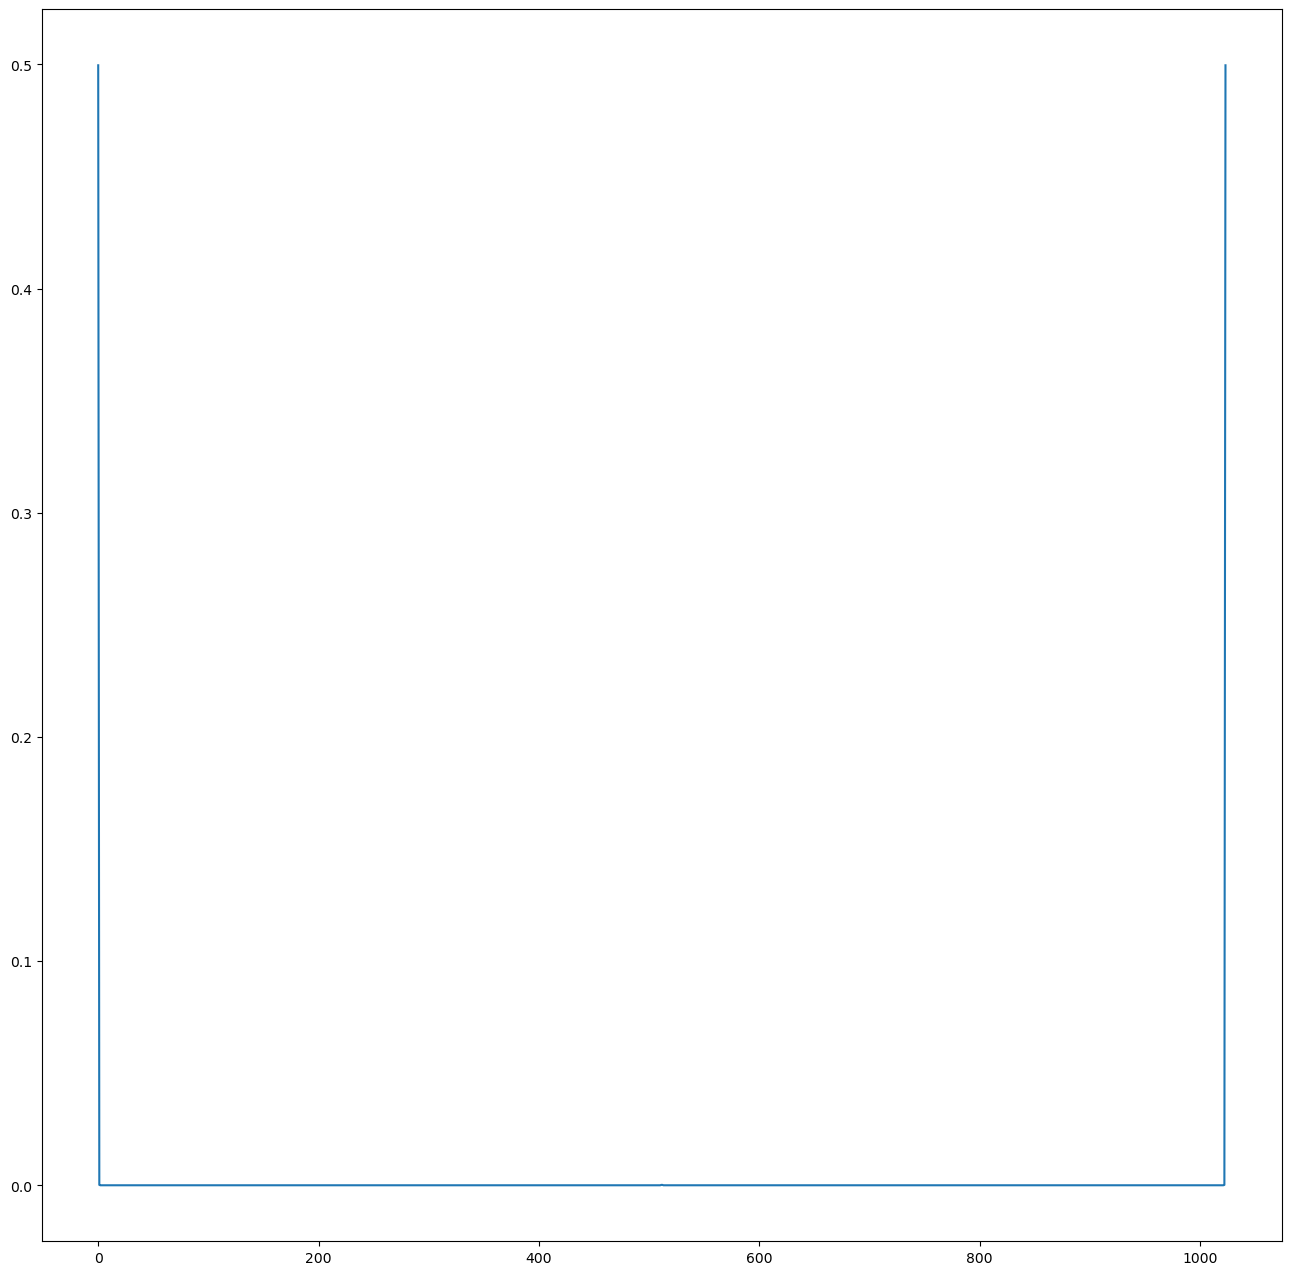

In [80]:
inference_4.run()

probability table:
          0         1
0  0.412854  0.087146
1  0.087146  0.412854


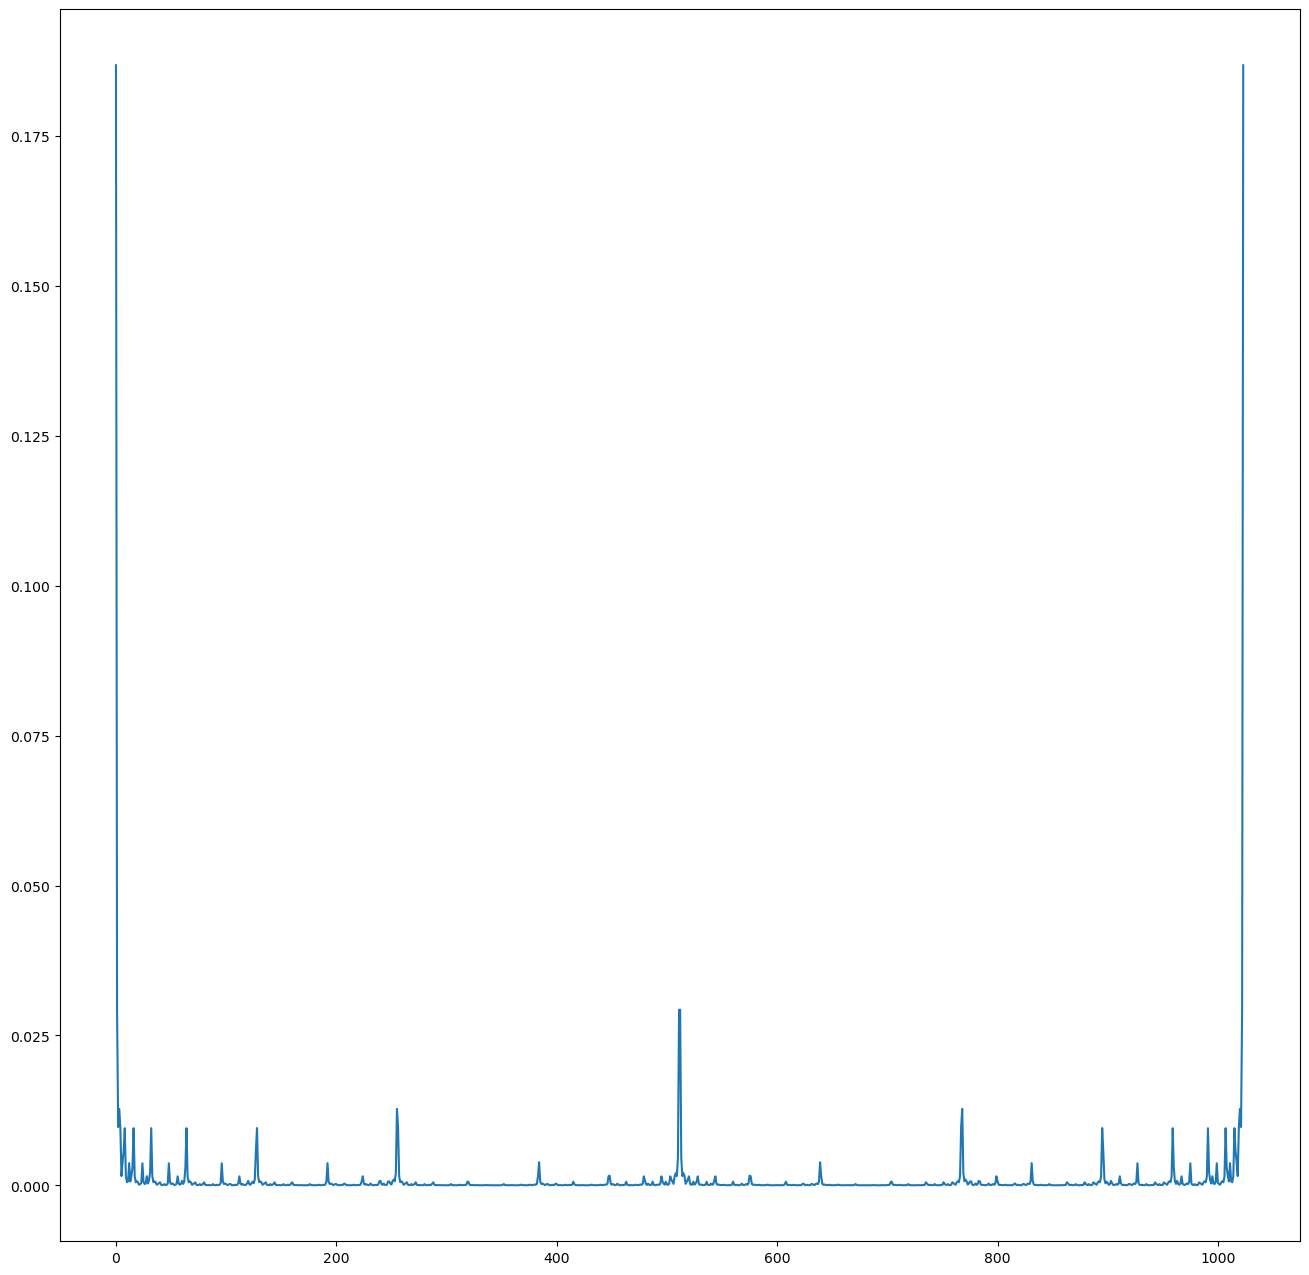

In [82]:
inference_1.run()

probability table:
         0        1
0  0.25125  0.24875
1  0.24875  0.25125


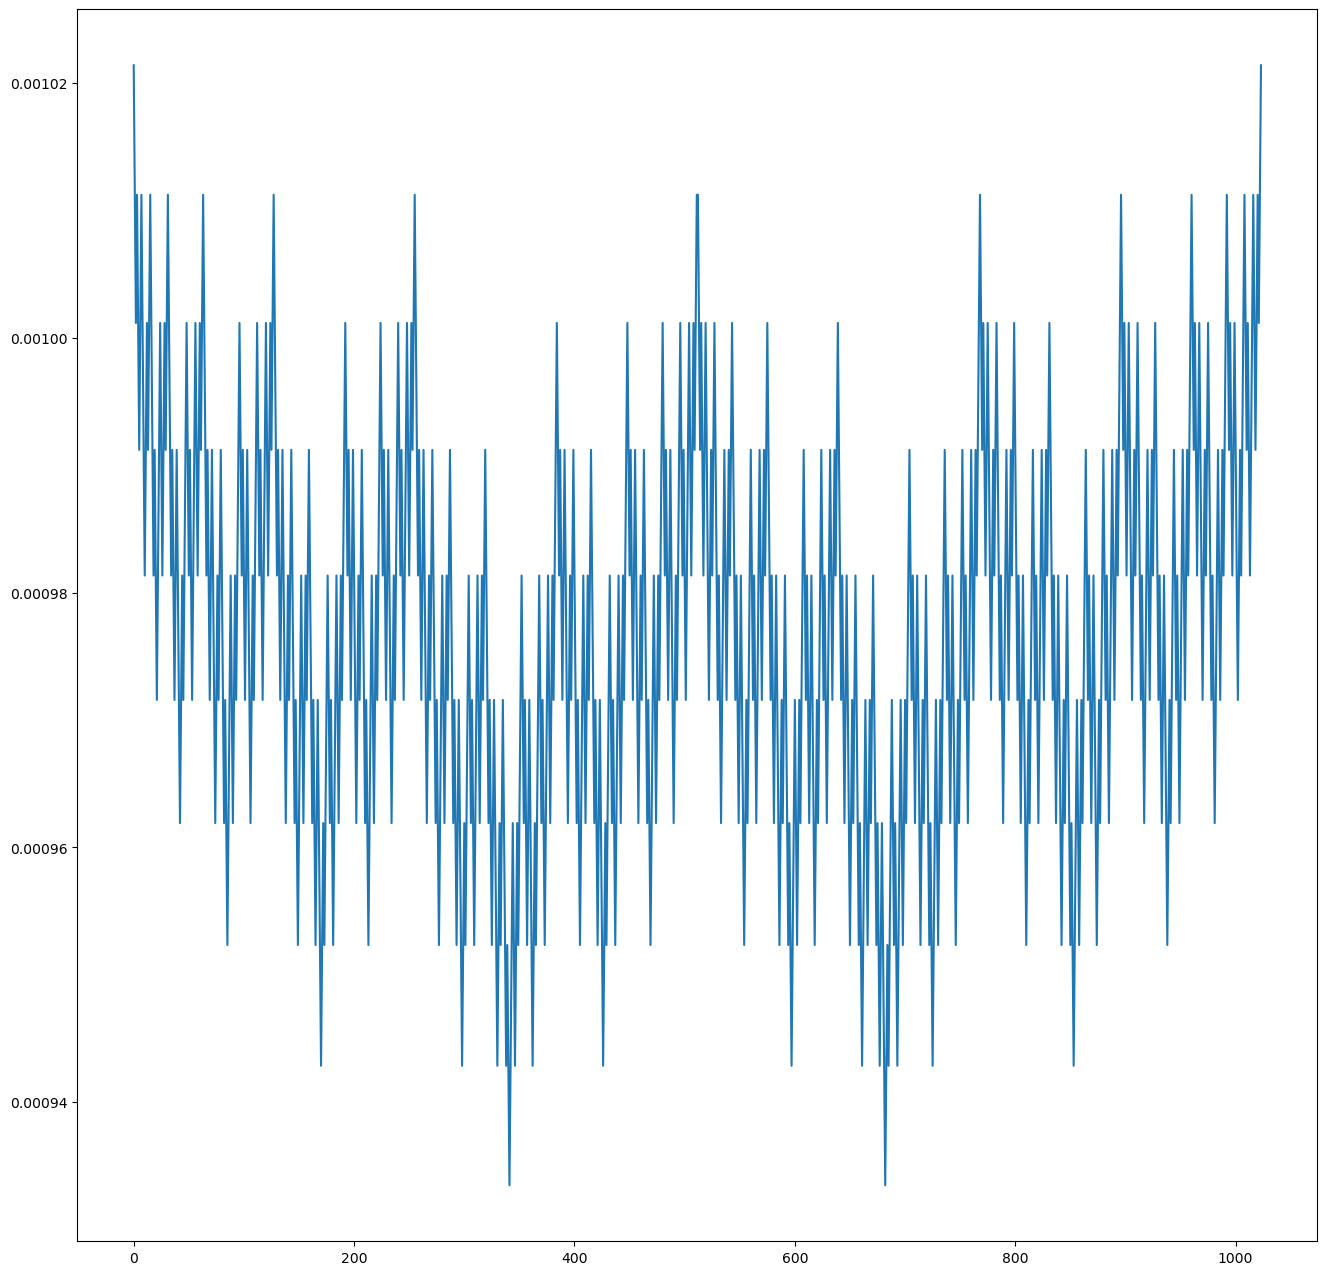

In [83]:
inference_001.run()